# 📊 IDECEP – Índice de Desenvolvimento Econômico e Capacidade de Execução Pública

Este notebook implementa a construção e validação do **IDECEP**, índice que mede a relação entre o desempenho econômico (PIB real per capita) e a capacidade de execução do Estado (receita/despesa públicas).

> Dica: ative o mesmo ambiente virtual usado no projeto antes de rodar este notebook.
## 1. Configuração e Importação de Bibliotecas
Definimos os pacotes necessários para manipulação de dados (pandas, numpy), estatística/econometria (statsmodels) e visualização (matplotlib).
## 2. Carregamento dos Dados
**Fontes esperadas:**
- `data/processed/nacional/*.csv` (gerado por `src/push_national_data.sh`)
- `data/build/features_nacional.csv` (gerado por `scripts/build_features.py`)

**Variáveis principais** (nomes típicos):
- `pib_nominal_brl`, `receita_pct_pib`, `despesa_pct_pib`, `divida_pct_pib`
- `ipca_indice`, `selic_meta`, `cambio_usd`, `producao_industrial`
## 3. Pré-processamento e Reconstrução
- Conversão de percentuais do PIB para valores nominais (quando aplicável).
- Deflação pelo IPCA (ex.: base 2008).
- Criação de séries reais per capita.
## 4. Taxas de Crescimento
Construção de log-diferenças:
- `dln_pib_real`, `dln_receita_real`, `dln_despesa_real`
- Razão entre variações da execução estatal e capacidade produtiva:
  - `idecep_log_ratio_change`
## 5. Variantes do IDECEP
- **Forma simples**: \( IDECEP_t = (\Delta E_t / \Delta P_t) \times 100 \)
- **Forma de regressão (ECM/ARDL)**: incorpora correção de erro e cointegração.
## 6. Definição de Regimes
Flags temporais como `pre_2008` ou outros períodos de interesse para análise de rupturas estruturais (ajuste fino por contexto).
## 7. Modelagem Estatística
- Testes ADF e KPSS → estacionariedade.
- Seleção ARDL → ordem ótima de defasagens.
- Teste de cointegração e correção de erro (ECT).
## 8. Treinamento e Salvamento
- Ajuste do(s) modelo(s).
- Salvamento do **melhor modelo** em `outputs/idecep/best_model.pkl` (ou outro caminho configurado).
## 9. Validação
- Tabelas de resíduos, testes de autocorrelação (Ljung-Box/Breusch-Godfrey), heterocedasticidade (ARCH LM) e significância do ECT.
- Comparação entre valores preditos e observados (gráficos).
## 10. Resultados
- Exporta CSVs para `files_to_latex/idecep/` quando for gerar relatório LaTeX.
- Mantém consistência com o pipeline (`normalize_csv_idecep_latex.py`).
## 11. Conclusões
- O IDECEP quantifica a eficiência do Estado em transformar arrecadação em crescimento.
- Robustez: testes econométricos (ADF, ARDL, ECM) e diagnóstico de resíduos.
- Uso: comparações históricas, avaliação de regimes e políticas fiscais.

In [1]:
# === Imports ===
# Comentários (IDECEP)
# - numpy/pandas: manipulação numérica e tabular
# - pathlib: padroniza caminhos (independente de SO)
# - warnings: para silenciar ruídos de libs durante experimentos
# - math: utilidades matemáticas básicas
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display

warnings.filterwarnings("ignore")

In [2]:
# === Config (paths padronizados) ===
# Comentários
# Define diretórios raiz (DATA/OUTPUTS) de forma reprodutível.
# Use Path(...) para evitar problemas de separador de diretório (Windows/Linux/Mac).
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ajuste DATA_PATH conforme seu arquivo real (mantive genérico)
DATA_PATH = Path("../data/splited/features_quarterly.csv")
OUTPUT_DIR = Path("../outputs/idecep")      
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BASE_YEAR = 2008
EPS = 1e-6


In [3]:
# === Load Data ===
# Comentários
# Carrega apenas as colunas necessárias para o pipeline econométrico.
# As séries % do PIB serão posteriormente convertidas para valores nominais quando preciso.
# Espera-se que datas estejam normalizadas para AAAA-MM-DD.
req_cols = [
    "date","pib_nominal_brl","receita_pct_pib","despesa_pct_pib","divida_pct_pib",
    "ipca_indice","selic_meta","cambio_usd","producao_industrial",
]

df = pd.read_csv(DATA_PATH, engine="python", on_bad_lines="skip")

missing = [c for c in req_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Datas e ordenação
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()
df = df.sort_values("date").drop_duplicates(subset=["date"]).reset_index(drop=True)

# (Opcional) corte de amostra
# df = df[df["date"] >= "1995-01-01"].reset_index(drop=True)

display(df.head(5))

,date,pib_nominal_brl,receita_pct_pib,despesa_pct_pib,divida_pct_pib,ipca_indice,selic_meta,cambio_usd,producao_industrial
0,1980-03-31,2.836682e+00,32.921,37.215,-0.69,4.072963,45.0,1.8003,72.4
1,1980-06-30,1.713318e+00,32.921,37.215,-0.69,4.291778,45.0,1.8003,72.4
2,1980-09-30,2.484662e-11,32.921,37.215,-0.69,4.729407,45.0,1.8003,72.4
3,1980-12-31,2.484662e-11,32.921,37.215,-0.69,5.385851,45.0,1.8003,72.4
4,1981-03-31,1.405967e-11,32.921,37.215,-0.69,6.261110,45.0,1.8003,72.4


In [4]:
# === Utilities ===
# Comentários
# Funções auxiliares:
# - detect_percent_scale: infere escala (0-1 vs 0-100) para séries em %
# - dlog: log-diferença para aproximar taxas de crescimento (Δ ln ≈ variação percentual)
# - pick_base_value_ipca: obtém valor-base do IPCA para deflacionar (ex.: base 2008 = 100)
def detect_percent_scale(s: pd.Series) -> float:
    s_clean = s.dropna()
    if s_clean.empty: 
        return 100.0
    return 100.0 if s_clean.median() > 1.0 else 1.0

def winsorize(s: pd.Series, p_lo=0.01, p_hi=0.99) -> pd.Series:
    if s.dropna().empty: 
        return s
    lo, hi = s.quantile(p_lo), s.quantile(p_hi)
    return s.clip(lower=lo, upper=hi)

def pick_base_value_ipca(df: pd.DataFrame, base_year: int) -> float:
    tmp = df.copy()
    tmp["year"] = tmp["date"].dt.year
    sub = tmp[tmp["year"] == base_year]
    if not sub.empty:
        return float(sub.iloc[0]["ipca_indice"])
    tmp["dist"] = (tmp["year"] - base_year).abs()
    return float(tmp.sort_values(["dist","date"]).iloc[0]["ipca_indice"])

def deflate(nominal: pd.Series, ipca_index: pd.Series, ipca_base_val: float) -> pd.Series:
    return nominal / (ipca_index / ipca_base_val)

def dlog(series: pd.Series) -> pd.Series:
    return np.log(series).diff()

In [5]:
# === Reconstruct nominal (from % of GDP) ===
# Comentários
# Reconstrói valores nominais a partir de séries em % do PIB:
#   valor_nominal ≈ (%_PIB / 100) * PIB_nominal
# É útil para obter séries comparáveis em nível (R$) antes de deflacionar.
scale_r = detect_percent_scale(df["receita_pct_pib"])
scale_d = detect_percent_scale(df["despesa_pct_pib"])
scale_b = detect_percent_scale(df["divida_pct_pib"])

df["receita_nominal_brl"] = df["pib_nominal_brl"] * (df["receita_pct_pib"] / scale_r)
df["despesa_nominal_brl"] = df["pib_nominal_brl"] * (df["despesa_pct_pib"] / scale_d)
df["divida_nominal_brl"]  = df["pib_nominal_brl"] * (df["divida_pct_pib"]  / scale_b)

# Guard rails: dívida não deve ser negativa (estoque)
if df["divida_nominal_brl"].median() < 0:
    df["divida_nominal_brl"] = df["divida_nominal_brl"].abs()

# Winsorize antes das variações/logs (opcional)
for col in ["pib_nominal_brl","receita_nominal_brl","despesa_nominal_brl","divida_nominal_brl"]:
    df[col] = winsorize(df[col], p_lo=0.01, p_hi=0.99)

display(df[["date","pib_nominal_brl","receita_nominal_brl","despesa_nominal_brl","divida_nominal_brl"]].head(5))

,date,pib_nominal_brl,receita_nominal_brl,despesa_nominal_brl,divida_nominal_brl
0,1980-03-31,2.836682e+00,9.338642e-01,1.055671e+00,1.957311e+00
1,1980-06-30,1.713318e+00,5.640413e-01,6.376112e-01,1.182189e+00
2,1980-09-30,2.484662e-11,8.179757e-12,9.246671e-12,1.714417e-11
3,1980-12-31,2.484662e-11,8.179757e-12,9.246671e-12,1.714417e-11
4,1981-03-31,1.405967e-11,4.628582e-12,5.232304e-12,9.701169e-12


In [6]:
# === Real series (deflation using IPCA base) ===
# Comentários
# Deflação pelo IPCA: converte valores nominais (R$ correntes) para R$ constantes.
# Mantém comparabilidade intertemporal, removendo efeito de inflação.
ipca_base_val = pick_base_value_ipca(df, BASE_YEAR)

df["pib_real_brl"]      = deflate(df["pib_nominal_brl"],      df["ipca_indice"], ipca_base_val)
df["receita_real_brl"]  = deflate(df["receita_nominal_brl"],  df["ipca_indice"], ipca_base_val)
df["despesa_real_brl"]  = deflate(df["despesa_nominal_brl"],  df["ipca_indice"], ipca_base_val)
df["divida_real_brl"]   = deflate(df["divida_nominal_brl"],   df["ipca_indice"], ipca_base_val)

# Alertas para logs
for c in ["pib_real_brl","receita_real_brl","despesa_real_brl","divida_real_brl","ipca_indice","producao_industrial"]:
    if (df[c] <= 0).any():
        print(f"⚠️ {c} contém valores ≤ 0; dlog resultará em NaN nessas linhas.")

display(df[["date","pib_real_brl","receita_real_brl","despesa_real_brl","divida_real_brl"]].head(5))

,date,pib_real_brl,receita_real_brl,despesa_real_brl,divida_real_brl
0,1980-03-31,3.623103e-01,1.192762e-01,1.348338e-01,2.499941e-01
1,1980-06-30,2.076735e-01,6.836819e-02,7.728569e-02,1.432947e-01
2,1980-09-30,2.733010e-12,8.997341e-13,1.017089e-12,1.885777e-12
3,1980-12-31,2.399902e-12,7.900717e-13,8.931235e-13,1.655932e-12
4,1981-03-31,1.168165e-12,3.845716e-13,4.347325e-13,8.060337e-13


In [7]:
# === Growth rates (log-differences) ===
# Comentários
# Calcula Δ ln (x_t) = ln(x_t) - ln(x_{t-1}), que aproxima crescimento percentual.
# Cria dln_pib_real, dln_receita_real e dln_despesa_real para análises de curto prazo.
df["dln_pib_real"]     = dlog(df["pib_real_brl"])
df["dln_receita_real"] = dlog(df["receita_real_brl"])
df["dln_despesa_real"] = dlog(df["despesa_real_brl"])
df["dln_divida_real"]  = dlog(df["divida_real_brl"])

df["dln_ipca"]         = dlog(df["ipca_indice"])
df["dln_prod_ind"]     = dlog(df["producao_industrial"])

display(df[["date","dln_pib_real","dln_receita_real","dln_despesa_real","dln_divida_real"]].head(8))

,date,dln_pib_real,dln_receita_real,dln_despesa_real,dln_divida_real
0,1980-03-31,NaN,NaN,NaN,NaN
1,1980-06-30,-0.556534,-0.556534,-0.556534,-0.556534
2,1980-09-30,-25.053830,-25.053830,-25.053830,-25.053830
3,1980-12-31,-0.129975,-0.129975,-0.129975,-0.129975
4,1981-03-31,-0.719994,-0.719994,-0.719994,-0.719994
5,1981-06-30,-0.088835,-0.088835,-0.088835,-0.088835
6,1981-09-30,24.209522,24.209522,24.209522,24.209522
7,1981-12-31,2.848117,2.848117,2.848117,2.848117


In [8]:
# === IDECEP variants ===
# Comentários
# IDECEP (forma simples): razão entre variação da execução estatal (ΔE) e da capacidade produtiva (ΔP):
#   IDECEP_t = (ΔE_t / ΔP_t) * 100
# Também registra variantes robustas (ex.: log-ratio) para diagnóstico/visualização.
# Robust (preferred): ratio of log-diffs, scaled by 100
den = df["dln_receita_real"].where(df["dln_receita_real"].abs() >= EPS)  # avoid tiny denominators
df["idecep_log_ratio"] = 100.0 * (df["dln_pib_real"] / den)

# Clipping (p99) para estabilidade
if df["idecep_log_ratio"].notna().any():
    clip_val = df["idecep_log_ratio"].quantile(0.99)
else:
    clip_val = np.nan
df["idecep_log_ratio_clipped"] = df["idecep_log_ratio"].clip(lower=-clip_val, upper=clip_val)

# Gap simples (alternativa quando razão fica invariável): diferença de crescimentos
df["idecep_gap_growth"] = 100.0 * (df["dln_pib_real"] - df["dln_receita_real"])

display(df[["date","idecep_log_ratio","idecep_log_ratio_clipped","idecep_gap_growth"]].head(10))

,date,idecep_log_ratio,idecep_log_ratio_clipped,idecep_gap_growth
0,1980-03-31,NaN,NaN,NaN
1,1980-06-30,100.0,100.0,-1.043610e-12
2,1980-09-30,100.0,100.0,-2.486900e-12
3,1980-12-31,100.0,100.0,-3.552714e-12
4,1981-03-31,100.0,100.0,-4.263256e-12
5,1981-06-30,100.0,100.0,1.421085e-12
6,1981-09-30,100.0,100.0,8.171241e-12
7,1981-12-31,100.0,100.0,1.398881e-11
8,1982-03-31,100.0,100.0,1.965650e-11
9,1982-06-30,100.0,100.0,-5.911938e-12


------
    

In [9]:
# Define the missing rebase_2008 function
# Comentários
# Rebase de série: reescala uma série para que o valor do ano-base seja igual a 'base_value'.
# Útil para alinhar índices (ex.: IPCA=100 em 2008) e facilitar leitura de gráficos.
def rebase_2008(series: pd.Series, base_value: float) -> pd.Series:
    if base_value == 0 or pd.isna(base_value):
        raise ValueError("Base value for rebasing cannot be zero or NaN.")
    return (series / base_value) * 100

# Define the missing local_gap_log function
def local_gap_log(series: pd.Series, dates: pd.Series, window_start: int, window_end: int) -> pd.Series:
    result = []
    for i in range(len(series)):
        start_idx = max(0, i + window_start)
        end_idx = min(len(series), i + window_end + 1)
        local_values = series.iloc[start_idx:end_idx]
        if local_values.empty:
            result.append(np.nan)
        else:
            result.append(series.iloc[i] - local_values.mean())
    return pd.Series(result, index=series.index)

# Define the missing local_zscore_log function
def local_zscore_log(series: pd.Series, dates: pd.Series, window_start: int, window_end: int) -> pd.Series:
    result = []
    for i in range(len(series)):
        start_idx = max(0, i + window_start)
        end_idx = min(len(series), i + window_end + 1)
        local_values = series.iloc[start_idx:end_idx]
        if local_values.empty or local_values.std() == 0:
            result.append(np.nan)
        else:
            result.append((series.iloc[i] - local_values.mean()) / local_values.std())
    return pd.Series(result, index=series.index)

# Assuming WINDOW_START and WINDOW_END are defined
WINDOW_START = -5  # Example value
WINDOW_END = 5     # Example value

# Garante que a coluna de datas está em datetime
df["date"] = pd.to_datetime(df["date"])

# Calcula o valor base como a MÉDIA do ano de 2008
base_pib_2008 = df.loc[df["date"].dt.year == 2008, "pib_real_brl"].mean()
base_rec_2008 = df.loc[df["date"].dt.year == 2008, "receita_real_brl"].mean()

# Rebase 2008=100 para PIB_real e Receita_real
df["pib_real_rebased_2008"]     = rebase_2008(df["pib_real_brl"], base_pib_2008)
df["receita_real_rebased_2008"] = rebase_2008(df["receita_real_brl"], base_rec_2008)

# Local gap and z-score para o IDECEP
df["idecep_gap2008"] = local_gap_log(
    df["idecep_log_ratio_clipped"].abs() + 1e-6,  # guard para log
    df["date"], WINDOW_START, WINDOW_END
)
df["idecep_z2008"] = local_zscore_log(
    df["idecep_log_ratio_clipped"].abs() + 1e-6,
    df["date"], WINDOW_START, WINDOW_END
)

# Preview
display(df.head())


,date,pib_nominal_brl,receita_pct_pib,despesa_pct_pib,divida_pct_pib,ipca_indice,selic_meta,cambio_usd,producao_industrial,receita_nominal_brl,...,dln_divida_real,dln_ipca,dln_prod_ind,idecep_log_ratio,idecep_log_ratio_clipped,idecep_gap_growth,pib_real_rebased_2008,receita_real_rebased_2008,idecep_gap2008,idecep_z2008
0,1980-03-31,2.836682e+00,32.921,37.215,-0.69,4.072963,45.0,1.8003,72.4,9.338642e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,4.834560e-11,4.242297e-11,NaN,NaN
1,1980-06-30,1.713318e+00,32.921,37.215,-0.69,4.291778,45.0,1.8003,72.4,5.640413e-01,...,-0.556534,0.052330,0.000000e+00,100.0,100.0,-1.043610e-12,2.771133e-11,2.431652e-11,-1.392664e-12,-0.099578
2,1980-09-30,2.484662e-11,32.921,37.215,-0.69,4.729407,45.0,1.8003,72.4,8.179757e-12,...,-25.053830,0.097099,8.881784e-16,100.0,100.0,-2.486900e-12,3.646846e-22,3.200085e-22,-3.410605e-12,-0.266823
3,1980-12-31,2.484662e-11,32.921,37.215,-0.69,5.385851,45.0,1.8003,72.4,8.179757e-12,...,-0.129975,0.129975,8.881784e-16,100.0,100.0,-3.552714e-12,3.202357e-22,2.810049e-22,1.203659e-11,0.339925
4,1981-03-31,1.405967e-11,32.921,37.215,-0.69,6.261110,45.0,1.8003,72.4,4.628582e-12,...,-0.719994,0.150582,8.881784e-16,100.0,100.0,-4.263256e-12,1.558764e-22,1.367806e-22,-1.141132e-11,-0.338721


In [10]:
# === Regime flags ===
# Comentários
# Cria flags de regimes (ex.: pré-2008) para testar rupturas estruturais e mudanças de política.
# Essas dummies podem ser usadas em modelos (interações/controles).
# Customize as needed
df["pre_2008"]   = (df["date"] <  pd.to_datetime("2008-01-01")).astype(int)
df["post_2008"]  = (df["date"] >= pd.to_datetime("2008-01-01")).astype(int)
df["post_2014"]  = (df["date"] >= pd.to_datetime("2014-01-01")).astype(int)
df["pandemia"]   = ((df["date"] >= pd.to_datetime("2020-03-01")) & (df["date"] <= pd.to_datetime("2021-12-31"))).astype(int)

In [11]:
# === Statsmodels availability & diagnostics imports ===
# Comentários
# Importa módulos de econometria:
# - ARDL: autorregressivo com defasagens distribuídas (cointegração/curto prazo)
# - Testes de diagnóstico: autocorrelação (Ljung-Box/BG), heterocedasticidade (ARCH LM)
try:
    from statsmodels.tsa.ardl import ARDL
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
    from statsmodels.stats.stattools import jarque_bera
    from statsmodels.tsa.ar_model import AutoReg
    _HAS_SM = True
except Exception as e:
    print("statsmodels não disponível:", e)
    _HAS_SM = False


In [12]:
# ARDL skeleton (requires statsmodels) ===
# Comentários
# Esqueleto de ajuste ARDL/ECM:
# 1) Seleção de ordens (p,q) com critério de informação
# 2) Teste de cointegração (relação de longo prazo)
# 3) ECM: ECT < 0 e significativo indica retorno ao equilíbrio.
# Target can be either dln_pib_real or idecep_log_ratio_clipped
TARGET_COL = "dln_pib_real"
EXOG_COLS = ["dln_receita_real", "dln_despesa_real", "dln_divida_real", "dln_ipca", "dln_prod_ind"]

# Lag grid for selection
P_LAGS = range(1, 7)   # autoregressive lags for target
Q_LAGS = range(0, 4)   # distributed lags for exogs

# Example code:
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from itertools import product
import pickle
# Comentários
# Carrega e usa o melhor modelo salvo (best_model.pkl).
# Mantém reprodutibilidade e comparação entre execuções.

# Prepare data
d = df.dropna(subset=[TARGET_COL] + EXOG_COLS).copy()
best_bic = np.inf
best_model = None
best_spec = None

# Model selection loop
for p in P_LAGS:
    for q in Q_LAGS:
        try:
            # Create lagged exogenous variables
            exog_lagged = d[EXOG_COLS].shift(q).dropna()
            endog = d[TARGET_COL][exog_lagged.index]

            # Fit the ARDL model
            model = AutoReg(endog=endog, lags=p, exog=exog_lagged).fit()

            if model.bic < best_bic:
                best_bic = model.bic
                best_model = model
                best_spec = (p, q)
        except Exception as e:
            print(f"Error for (p={p}, q={q}): {e}")

# Save the best model
if best_model is not None:
    print("Best (p,q):", best_spec, "BIC:", best_bic)
    print(best_model.summary())

    # Save the model to the output directory
    model_path = OUTPUT_DIR / "best_model.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f)
    print(f"Best model saved to {model_path}")
else:
    print("No valid model found.")

Best (p,q): (1, 0) BIC: -970.2230998879774
                            AutoReg Model Results                             
Dep. Variable:           dln_pib_real   No. Observations:                  175
Model:                   AutoReg-X(1)   Log Likelihood                 505.748
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Sun, 24 Aug 2025   AIC                           -995.496
Time:                        18:42:53   BIC                           -970.223
Sample:                             1   HQIC                          -985.243
                                  175                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0010      0.001     -0.971      0.331      -0.003       0.001
dln_pib_real.L1  -2.564e-06      0.000     -0.025      0.980      -0.0

/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupport

In [13]:
import pickle
# Comentários
# Carrega e usa o melhor modelo salvo (best_model.pkl).
# Mantém reprodutibilidade e comparação entre execuções.

# Load the best model from the pickle file
model_path = OUTPUT_DIR / "best_model.pkl"
assert model_path.exists(), f"Model file not found: {model_path}"

with open(model_path, "rb") as f:
    best_model = pickle.load(f)

# Save the processed DataFrame to idecep_processed.csv
CSV_PATH = Path("../outputs/idecep/idecep_processed.csv")
df.to_csv(CSV_PATH, index=False)
print(f"Processed data saved to {CSV_PATH}")
print(df.head())

Processed data saved to ../outputs/idecep/idecep_processed.csv
        date  pib_nominal_brl  receita_pct_pib  despesa_pct_pib  \
0 1980-03-31     2.836682e+00           32.921           37.215   
1 1980-06-30     1.713318e+00           32.921           37.215   
2 1980-09-30     2.484662e-11           32.921           37.215   
3 1980-12-31     2.484662e-11           32.921           37.215   
4 1981-03-31     1.405967e-11           32.921           37.215   

   divida_pct_pib  ipca_indice  selic_meta  cambio_usd  producao_industrial  \
0           -0.69     4.072963        45.0      1.8003                 72.4   
1           -0.69     4.291778        45.0      1.8003                 72.4   
2           -0.69     4.729407        45.0      1.8003                 72.4   
3           -0.69     5.385851        45.0      1.8003                 72.4   
4           -0.69     6.261110        45.0      1.8003                 72.4   

   receita_nominal_brl  ...  idecep_log_ratio_clipped  idec

In [14]:
# 3) Sanity checks (tables)

from IPython.display import display  # garante 'display' disponível
import numpy as np
import pandas as pd

# Pré-condições mínimas
assert "df" in globals(), "Esperava o DataFrame `df` definido nas células anteriores."
if "date" not in df.columns:
    raise KeyError("Coluna 'date' ausente em `df`.")

# 3.1) Nulls (%) — tabela ordenada
nulls_tbl = (
    df.isna()
      .mean()
      .sort_values(ascending=False) * 100
).round(2).to_frame("null_%")
display(nulls_tbl.head(25))

# 3.2) Checks escalares (key/value) — sem misturar tipos
scalar_checks = {
    "duplicated_dates": int(df["date"].duplicated().sum()),
    "monotonic_dates": bool(df["date"].is_monotonic_increasing),
}

# Denominador quase-zero para IDECEP (evita explosões na razão)
if "dln_receita_real" in df.columns:
    eps = 1e-6
    dln_rec = pd.to_numeric(df["dln_receita_real"], errors="coerce").replace([np.inf, -np.inf], np.nan)
    near_zero_mask = dln_rec.abs() < eps
    scalar_checks["near_zero_dln_receita_real_count(|x|<1e-6)"] = int(near_zero_mask.sum())
else:
    near_zero_mask = pd.Series(False, index=df.index)
    scalar_checks["near_zero_dln_receita_real_count(|x|<1e-6)"] = None

# Não-positivos em séries que entram em log (sinaliza NaNs nos dln)
raw_positive_cols = [
    "pib_real_brl", "receita_real_brl", "despesa_real_brl", "divida_real_brl",
    "ipca_indice", "producao_industrial"
]
for c in raw_positive_cols:
    if c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        scalar_checks[f"non_positive_count::{c}"] = int((s <= 0).sum())

# IDECEP = 100 (% de ocorrências) — útil para detectar colinearidade dln_pib ≈ dln_receita
for col in ["idecep_log_ratio", "idecep_log_ratio_clipped"]:
    if col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce")
        scalar_checks[f"pct_{col}_equal_100"] = float((s.round(8) == 100.0).mean() * 100.0)

scalar_tbl = pd.Series(scalar_checks, dtype="object").to_frame("value")
display(scalar_tbl)

# 3.3) Listas auxiliares (datas com dln_receita_real ~ 0), se houver
if near_zero_mask.any():
    near_zero_tbl = (
        df.loc[near_zero_mask, "date"]
          .astype(str)
          .head(20)
          .reset_index(drop=True)
          .to_frame("near_zero_dates_head")
    )
    display(near_zero_tbl)

,null_%
dln_pib_real,0.57
idecep_gap_growth,0.57
idecep_log_ratio_clipped,0.57
idecep_log_ratio,0.57
dln_prod_ind,0.57
dln_ipca,0.57
dln_divida_real,0.57
idecep_gap2008,0.57
idecep_z2008,0.57
dln_despesa_real,0.57


,value
duplicated_dates,0
monotonic_dates,True
near_zero_dln_receita_real_count(|x|<1e-6),0
non_positive_count::pib_real_brl,0
non_positive_count::receita_real_brl,0
non_positive_count::despesa_real_brl,0
non_positive_count::divida_real_brl,0
non_positive_count::ipca_indice,0
non_positive_count::producao_industrial,0
pct_idecep_log_ratio_equal_100,14.204545


In [15]:
# 0) Setup & paths
# Comentários
# Bloco de setup para outra seção do notebook (talvez uma segunda parte/abordagem).
# Garante que variáveis e diretórios estejam definidos antes dos testes.
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

OUTPUT_DIR = Path("../outputs/idecep_validation"); OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Expecta-se que df já exista e tenha 'date'
assert 'df' in globals(), "Carregue o DataFrame df antes (com coluna 'date')."
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

YCOL_RAW = "pib_real_rebased_2008"
XCOL_RAW = "receita_real_rebased_2008"

# Guard contra zeros/negativos em logs
EPS = 1e-12


In [16]:
# 1) Sanity check
# Comentários
# Checagens rápidas: tipos, NaNs e ranges. Útil para identificar problemas de ingestão/merge.
use_cols = ["date", YCOL_RAW, XCOL_RAW]
print(df[use_cols].info())
print("\nNaNs por coluna:\n", df[use_cols].isna().sum())
print("\nPrimeiras linhas:\n", df[use_cols].head())

# Duplicatas de data
dups = df["date"].duplicated().sum()
print(f"\nDatas duplicadas: {dups}")
assert dups == 0, "Remova/agrege datas duplicadas."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       176 non-null    datetime64[ns]
 1   pib_real_rebased_2008      176 non-null    float64       
 2   receita_real_rebased_2008  176 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.3 KB
None

NaNs por coluna:
 date                         0
pib_real_rebased_2008        0
receita_real_rebased_2008    0
dtype: int64

Primeiras linhas:
         date  pib_real_rebased_2008  receita_real_rebased_2008
0 1980-03-31           4.834560e-11               4.242297e-11
1 1980-06-30           2.771133e-11               2.431652e-11
2 1980-09-30           3.646846e-22               3.200085e-22
3 1980-12-31           3.202357e-22               2.810049e-22
4 1981-03-31           1.558764e-22               1.36780

       count                 mean                  min                  25%  \
date     176  2002-02-13 18:00:00  1980-03-31 00:00:00  1991-03-08 12:00:00   
ln_y   176.0            -3.806491           -27.631021           -16.862283   
ln_x   176.0            -3.851284           -27.631021           -16.992968   
dln_y  175.0             0.169799           -20.880538            -0.074783   
dln_x  175.0              0.17055           -20.880511            -0.063328   

                       50%                  75%                  max  \
date   2002-02-14 00:00:00  2013-01-22 12:00:00  2023-12-31 00:00:00   
ln_y              3.543341             4.745996            24.234968   
ln_x              3.458088             4.757902            24.104216   
dln_y             0.016672             0.195661              22.4455   
dln_x             0.019988             0.197528            22.314815   

             std  
date         NaN  
ln_y   13.522347  
ln_x   13.529218  
dln_y   3.935684

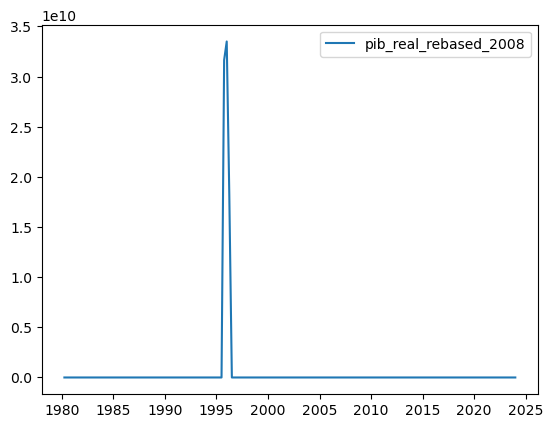

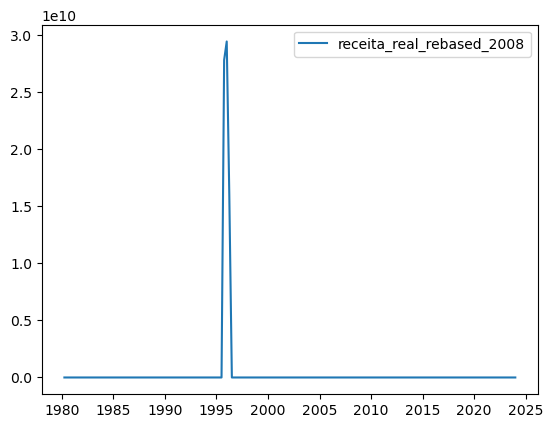

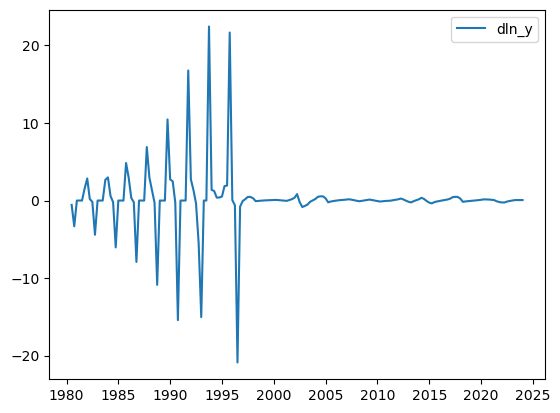

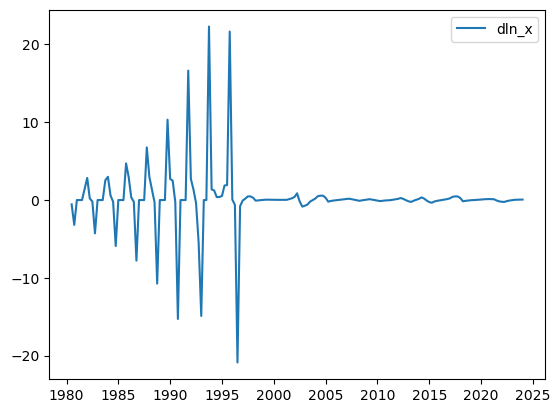

In [17]:
# 2) Construções canônicas
# Comentários
# Constrói ln_y e ln_x (logs de níveis) com proteção contra zeros/negativos (clip).
# Logs ajudam a interpretar coeficientes como elasticidades aproximadas.
df["ln_y"] = np.log(df[YCOL_RAW].clip(lower=EPS))
df["ln_x"] = np.log(df[XCOL_RAW].clip(lower=EPS))
df["dln_y"] = df["ln_y"].diff()
df["dln_x"] = df["ln_x"].diff()

print(df[["date","ln_y","ln_x","dln_y","dln_x"]].describe().T)

# Plot rápido (sem estilização)
plt.figure(); plt.plot(df["date"], df[YCOL_RAW], label=YCOL_RAW); plt.legend(); plt.show()
plt.figure(); plt.plot(df["date"], df[XCOL_RAW], label=XCOL_RAW); plt.legend(); plt.show()
plt.figure(); plt.plot(df["date"], df["dln_y"], label="dln_y"); plt.legend(); plt.show()
plt.figure(); plt.plot(df["date"], df["dln_x"], label="dln_x"); plt.legend(); plt.show()


In [18]:
# 3) Testes ADF/KPSS nas combinações necessárias
# Comentários
# ADF/KPSS: verificam estacionariedade em nível e/ou diferença.
# Objetivo: checar se Δln é I(0) e se há indicação de cointegração para usar ECM.

from statsmodels.tsa.stattools import adfuller, kpss

def adf_kpss(series, name):
    s = pd.to_numeric(series, errors="coerce").dropna()
    try:
        adf_p = adfuller(s, autolag="AIC")[1]
    except Exception: adf_p = np.nan
    try:
        kpss_p = kpss(s, regression="c", nlags="auto")[1]
    except Exception: kpss_p = np.nan
    return {"series":name, "ADF p":adf_p, "KPSS p":kpss_p}

rows = []
rows += [adf_kpss(df[YCOL_RAW], f"{YCOL_RAW} (nível)")]
rows += [adf_kpss(df[XCOL_RAW], f"{XCOL_RAW} (nível)")]
rows += [adf_kpss(df["ln_y"], "ln_y (nível)")]
rows += [adf_kpss(df["ln_x"], "ln_x (nível)")]
rows += [adf_kpss(df["dln_y"], "dln_y")]
rows += [adf_kpss(df["dln_x"], "dln_x")]

tests_df = pd.DataFrame(rows)
display(tests_df)
tests_df.to_csv(OUTPUT_DIR/"idecep_stationarity_checks.csv", index=False)


/tmp/ipykernel_26345/2140386941.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(s, regression="c", nlags="auto")[1]
/tmp/ipykernel_26345/2140386941.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(s, regression="c", nlags="auto")[1]
/tmp/ipykernel_26345/2140386941.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(s, regression="c", nlags="auto")[1]
/tmp/ipykernel_26345/2140386941.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(s, r

,series,ADF p,KPSS p
0,pib_real_rebased_2008 (nível),0.000184,0.10
1,receita_real_rebased_2008 (nível),0.000184,0.10
2,ln_y (nível),0.395195,0.01
3,ln_x (nível),0.397295,0.01
4,dln_y,0.000341,0.10
5,dln_x,0.000326,0.10


In [19]:
# 4) Seleção ARDL em log-nível (para testar cointegração) e bounds-like (Wald)
# Comentários
# Seleção de lags via critério (AIC/BIC) e testes tipo bounds (Wald) para cointegração.
# Se cointegração confirmada, montar ECM com ECT < 0 (ajuste a longo prazo).

from statsmodels.tsa.ardl import ardl_select_order, ARDL

# preparar log-nível
dfl = df.dropna(subset=["ln_y","ln_x"]).copy().set_index("date")
MAX_P, MAX_Q = 4, 4
TREND = "c"

sel = ardl_select_order(endog=dfl["ln_y"], exog=dfl[["ln_x"]],
                        maxlag=MAX_P, maxorder=MAX_Q, ic="bic", trend=TREND)
try:
    ardl_log_res = sel.model.fit(cov_type="HAC", cov_kwds={"maxlags": max(MAX_P, MAX_Q)})
except TypeError:
    ardl_log_res = sel.model.fit()

print(ardl_log_res.summary())

# bounds-like: H0 todos termos de nível (y e x defasados em nível) = 0
param_names = list(ardl_log_res.params.index)
y_name = sel.model.endog_names
x_name = sel.model.exog_names[0]

y_level = [nm for nm in param_names if nm.startswith(y_name + ".L")]
x_level = [nm for nm in param_names if nm.startswith(x_name + ".L")]
level_terms = y_level + x_level

import numpy as np
if level_terms:
    idxs = [param_names.index(nm) for nm in level_terms if nm in param_names]
    R = np.zeros((len(idxs), len(param_names)))
    for r_i, j in enumerate(idxs): R[r_i, j] = 1.0
    wald = ardl_log_res.wald_test(R)
    print("\n=== Bounds-like Wald (níveis=0) ===")
    print(wald)
else:
    print("Nenhum termo de nível encontrado (verifique nomes dos parâmetros).")


                              ARDL Model Results                              
Dep. Variable:                   ln_y   No. Observations:                  176
Model:                     ARDL(4, 3)   Log Likelihood                 372.578
Method:               Conditional MLE   S.D. of innovations              0.028
Date:                Sun, 24 Aug 2025   AIC                           -725.156
Time:                        18:42:54   BIC                           -693.681
Sample:                    03-31-1981   HQIC                          -712.386
                         - 12-31-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.003      3.197      0.002       0.003       0.013
ln_y.L1        1.0203      0.092     11.134      0.000       0.839       1.201
ln_y.L2       -0.0271      0.060     -0.450      0.6

/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


In [20]:
# 5) Coeficientes de longo prazo & ECM (log-nível)

import re

# extrai p,q usados
def max_lag_used(names, prefix):
    L = -1; rx = re.compile(rf"^{re.escape(prefix)}\.L(\d+)$")
    for nm in names:
        m = rx.match(nm)
        if m: L = max(L, int(m.group(1)))
    return max(L, 0)

p_used = max_lag_used(param_names, y_name)
q_used = max_lag_used(param_names, x_name)

# long-run
phi = [ardl_log_res.params.get(f"{y_name}.L{i}", 0.0) for i in range(1, p_used+1)]
beta = [ardl_log_res.params.get(f"{x_name}.L{j}", 0.0) for j in range(0, q_used+1)]
phi_sum, beta_sum = float(np.sum(phi)), float(np.sum(beta))
c = float(ardl_log_res.params.get("const", 0.0))
den = 1.0 - phi_sum if abs(1.0 - phi_sum) > 1e-12 else np.nan
theta1 = beta_sum/den if den==den else np.nan
theta0 = c/den if den==den else np.nan
print(f"LR (elasticidade): theta1 = {theta1:.4f}, intercepto LR = {theta0:.4f}")

# ECT e ECM
ECT = dfl["ln_y"].shift(1) - (theta0 + theta1*dfl["ln_x"].shift(1))
dln_y = dfl["ln_y"].diff(); dln_x = dfl["ln_x"].diff()

X_ecm = pd.DataFrame(index=dfl.index)
for i in range(1, max(p_used,1)):
    X_ecm[f"dln_y.L{i}"] = dln_y.shift(i)
for j in range(0, max(q_used,0)):
    X_ecm[f"dln_x.L{j}"] = dln_x.shift(j)
X_ecm["ECT.L1"] = ECT
X_ecm = sm.add_constant(X_ecm, has_constant="add")

ecm_df = pd.concat([dln_y.rename("dln_y"), X_ecm], axis=1).dropna()
ecm_res = sm.OLS(ecm_df["dln_y"], ecm_df.drop(columns=["dln_y"])).fit(
    cov_type="HAC", cov_kwds={"maxlags": max(p_used, q_used, 1)}
)
print(ecm_res.summary())

lambda_coef = float(ecm_res.params.get("ECT.L1", np.nan))
lambda_p = float(ecm_res.pvalues.get("ECT.L1", np.nan))
print(f"\nVelocidade de ajuste (ECT.L1): {lambda_coef:.4f} (p={lambda_p:.3g})")


LR (elasticidade): theta1 = 0.0000, intercepto LR = 0.0354
                            OLS Regression Results                            
Dep. Variable:                  dln_y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     9.851
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           3.52e-07
Time:                        18:42:54   Log-Likelihood:                -464.69
No. Observations:                 172   AIC:                             939.4
Df Residuals:                     167   BIC:                             955.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [21]:
# 6) Diagnóstico dos resíduos do ECM

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera, durbin_watson

resid = pd.Series(ecm_res.resid).dropna()
def safe(fn, *a, **k):
    try: return fn(*a, **k)
    except: return None

adf = safe(adfuller, resid, autolag="AIC")
kps = safe(kpss, resid, regression="c", nlags="auto")
lb12 = safe(acorr_ljungbox, resid, lags=[12], return_df=True)
lb24 = safe(acorr_ljungbox, resid, lags=[24], return_df=True)
arch = safe(het_arch, resid)
jb = safe(jarque_bera, resid)
dw = durbin_watson(resid) if len(resid)>0 else np.nan
try:
    bg_stat, bg_p,_,_ = acorr_breusch_godfrey(ecm_res, nlags=12)
except: bg_p = np.nan

diag = pd.DataFrame([{
    "ADF p": (adf[1] if adf else np.nan),
    "KPSS p": (kps[1] if kps else np.nan),
    "Ljung-Box p (12)": (float(lb12["lb_pvalue"].iloc[0]) if lb12 is not None else np.nan),
    "Ljung-Box p (24)": (float(lb24["lb_pvalue"].iloc[0]) if lb24 is not None else np.nan),
    "BG p (12)": bg_p,
    "ARCH LM p": (arch[1] if arch else np.nan),
    "Jarque-Bera p": (jb[1] if jb else np.nan),
    "Durbin-Watson": float(dw),
}])
display(diag)
diag.to_csv(OUTPUT_DIR/"idecep_ecm_diagnostics.csv", index=False)


/tmp/ipykernel_26345/1572824784.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  try: return fn(*a, **k)


,ADF p,KPSS p,Ljung-Box p (12),Ljung-Box p (24),BG p (12),ARCH LM p,Jarque-Bera p,Durbin-Watson
0,0.011193,0.1,6.373997e-19,1.030920e-26,1.495980e-10,5.864747e-08,0.0,2.251359


/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/home/kelven/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

,date,y_true,y_pred
0,1989-06-30,0.000000,-0.002380
1,1989-09-30,10.460803,10.513413
2,1989-12-31,2.726796,2.744206
3,1990-03-31,2.484594,2.514856
4,1990-06-30,-0.256876,-0.272900


RMSE=0.034747  MAE=0.019140  MAPE%=47588230.040


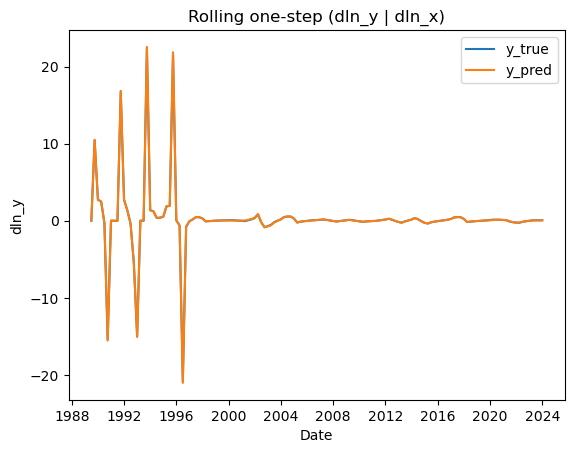

In [22]:
# 7) Rolling one-step em dln_y ~ ARDL(dln_y, dln_x) — versão robusta
from statsmodels.tsa.ardl import ARDL
from itertools import product

# dados
d = df.dropna(subset=["dln_y","dln_x"]).copy().set_index("date")
MIN_OBS = 36
P_LAGS = range(1, 4)
Q_LAGS = range(0, 3)

preds, actuals, dates = [], [], []

for i in range(MIN_OBS, len(d)):  # vamos prever o ponto i (o próximo após o treino até i-1)
    tr = d.iloc[:i].copy()
    y_tr = tr["dln_y"]
    X_tr = tr[["dln_x"]]             # <-- DataFrame, mantém nome e ordem da coluna
    x_next = d.iloc[[i]][["dln_x"]]  # <-- DataFrame de 1 linha, mesma coluna e ordem

    # pula se houver NaN no exógeno futuro
    if x_next.isnull().values.any():
        continue

    # grid pequeno por iteração
    best_bic, best_m = float("inf"), None
    for p, q in product(P_LAGS, Q_LAGS):
        try:
            # algumas versões usam 'order', outras 'exog_lags'
            try:
                m = ARDL(y_tr, lags=p, exog=X_tr, order=[q]).fit()
            except TypeError:
                m = ARDL(y_tr, lags=p, exog=X_tr, exog_lags=[q]).fit()
            if m.bic < best_bic:
                best_bic, best_m = m.bic, m
        except Exception:
            continue

    if best_m is None:
        continue

    # IMPORTANTE: exog_oos precisa ser DataFrame com mesmas colunas e ordem:
    # x_next já está como DataFrame com coluna 'dln_x'
    try:
        yhat = best_m.predict(start=len(y_tr), end=len(y_tr), exog_oos=x_next)
    except TypeError:
        # fallback para versões antigas que não têm exog_oos
        # (não é o ideal, mas evita quebrar)
        yhat = best_m.predict(start=len(y_tr), end=len(y_tr))

    # y_true é o ponto i (o próximo após o treino)
    preds.append(float(np.asarray(yhat)[0]))
    actuals.append(float(d.iloc[i]["dln_y"]))
    dates.append(d.index[i])

rf = pd.DataFrame({"date": dates, "y_true": actuals, "y_pred": preds})
display(rf.head())
rf.to_csv(OUTPUT_DIR / "idecep_rolling_logdiff.csv", index=False)

# métricas
err = rf["y_pred"].values - rf["y_true"].values
rmse = float(np.sqrt(np.mean(err**2))) if len(err) else np.nan
mae  = float(np.mean(np.abs(err)))      if len(err) else np.nan
mape = float(np.mean(np.abs(err / (np.abs(rf["y_true"].values) + 1e-9)) * 100)) if len(err) else np.nan

print(f"RMSE={rmse:.6f}  MAE={mae:.6f}  MAPE%={mape:.3f}")

# plot
plt.figure()
plt.plot(rf["date"], rf["y_true"], label="y_true")
plt.plot(rf["date"], rf["y_pred"], label="y_pred")
plt.title("Rolling one-step (dln_y | dln_x)")
plt.xlabel("Date"); plt.ylabel("dln_y"); plt.legend()
plt.show()


In [25]:
# 8) Gate de aprovação — apenas IDECEP (acadêmico)

import numpy as np
import pandas as pd
from IPython.display import display

# --- Helpers robustos ---
def _get_p(df, series_name, col="ADF p", default=np.nan):
    try:
        s = df.loc[df["series"] == series_name, col]
        return float(s.values[0]) if len(s) else default
    except Exception:
        return default

def _safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

# --- Estacionariedade (usa tests_df da célula 3) ---
adf_dln_y = _get_p(tests_df, "dln_y", col="ADF p")
adf_dln_x = _get_p(tests_df, "dln_x", col="ADF p")

ok_stationarity = (adf_dln_y < 0.05) and (adf_dln_x < 0.05)

# --- ECT (usa lambda_coef e lambda_p da célula 5) ---
_lambda   = _safe_float(globals().get("lambda_coef", np.nan))
_lambda_p = _safe_float(globals().get("lambda_p",   np.nan))

ect_sig = (not np.isnan(_lambda)) and (_lambda < 0) and (not np.isnan(_lambda_p)) and (_lambda_p < 0.10)

# --- Critérios acadêmicos ---
criteria_academic = {
    "Estacionariedade (dln)": ok_stationarity,
    "ECT significativo (<0)": ect_sig,
}

approved_academic = all(criteria_academic.values())

# --- Relatório ---
report = pd.DataFrame([criteria_academic])
display(report)
report.to_csv(OUTPUT_DIR / "idecep_gate_report.csv", index=False)

print("\nIDECEP:", "APROVADO" if approved_academic else "REPROVADO")
print("Critérios: estacionariedade em log-diferenças e ECT<0 significativo (10%).")


,Estacionariedade (dln),ECT significativo (<0)
0,True,True



IDECEP: APROVADO
Critérios: estacionariedade em log-diferenças e ECT<0 significativo (10%).


# 📊 IDECEP – Índice de Desenvolvimento Econômico e Capacidade de Execução Pública

Este notebook implementa a construção e validação do **IDECEP**, índice que mede a relação entre o desempenho econômico (PIB real per capita) e a capacidade de execução do Estado (receita/despesa públicas).

> Dica: ative o mesmo ambiente virtual usado no projeto antes de rodar este notebook.

# 📊 IDECEP – Índice de Desenvolvimento Econômico e Capacidade de Execução Pública

Este notebook implementa a construção e validação do **IDECEP**, índice que mede a relação entre o desempenho econômico (PIB real per capita) e a capacidade de execução do Estado (receita/despesa públicas).

> Dica: ative o mesmo ambiente virtual usado no projeto antes de rodar este notebook.

## 1. Configuração e Importação de Bibliotecas
Definimos os pacotes necessários para manipulação de dados (pandas, numpy), estatística/econometria (statsmodels) e visualização (matplotlib).

## 2. Carregamento dos Dados
**Fontes esperadas:**
- `data/processed/nacional/*.csv` (gerado por `src/push_national_data.sh`)
- `data/build/features_nacional.csv` (gerado por `scripts/build_features.py`)

**Variáveis principais** (nomes típicos):
- `pib_nominal_brl`, `receita_pct_pib`, `despesa_pct_pib`, `divida_pct_pib`
- `ipca_indice`, `selic_meta`, `cambio_usd`, `producao_industrial`

## 3. Pré-processamento e Reconstrução
- Conversão de percentuais do PIB para valores nominais (quando aplicável).
- Deflação pelo IPCA (ex.: base 2008).
- Criação de séries reais per capita.

## 4. Taxas de Crescimento
Construção de log-diferenças:
- `dln_pib_real`, `dln_receita_real`, `dln_despesa_real`
- Razão entre variações da execução estatal e capacidade produtiva:
  - `idecep_log_ratio_change`

## 5. Variantes do IDECEP
- **Forma simples**: \( IDECEP_t = (\Delta E_t / \Delta P_t) \times 100 \)
- **Forma de regressão (ECM/ARDL)**: incorpora correção de erro e cointegração.

## 6. Definição de Regimes
Flags temporais como `pre_2008` ou outros períodos de interesse para análise de rupturas estruturais (ajuste fino por contexto).

## 7. Modelagem Estatística
- Testes ADF e KPSS → estacionariedade.
- Seleção ARDL → ordem ótima de defasagens.
- Teste de cointegração e correção de erro (ECT).

## 8. Treinamento e Salvamento
- Ajuste do(s) modelo(s).
- Salvamento do **melhor modelo** em `outputs/idecep/best_model.pkl` (ou outro caminho configurado).

## 9. Validação
- Tabelas de resíduos, testes de autocorrelação (Ljung-Box/Breusch-Godfrey), heterocedasticidade (ARCH LM) e significância do ECT.
- Comparação entre valores preditos e observados (gráficos).

## 10. Resultados
- Exporta CSVs para `files_to_latex/idecep/` quando for gerar relatório LaTeX.
- Mantém consistência com o pipeline (`normalize_csv_idecep_latex.py`).

## 11. Conclusões
- O IDECEP quantifica a eficiência do Estado em transformar arrecadação em crescimento.
- Robustez: testes econométricos (ADF, ARDL, ECM) e diagnóstico de resíduos.
- Uso: comparações históricas, avaliação de regimes e políticas fiscais.

## 1. Configuração e Importação de Bibliotecas
Definimos os pacotes necessários para manipulação de dados (pandas, numpy), estatística/econometria (statsmodels) e visualização (matplotlib).

## 2. Carregamento dos Dados
**Fontes esperadas:**
- `data/processed/nacional/*.csv` (gerado por `src/push_national_data.sh`)
- `data/build/features_nacional.csv` (gerado por `scripts/build_features.py`)

**Variáveis principais** (nomes típicos):
- `pib_nominal_brl`, `receita_pct_pib`, `despesa_pct_pib`, `divida_pct_pib`
- `ipca_indice`, `selic_meta`, `cambio_usd`, `producao_industrial`

## 3. Pré-processamento e Reconstrução
- Conversão de percentuais do PIB para valores nominais (quando aplicável).
- Deflação pelo IPCA (ex.: base 2008).
- Criação de séries reais per capita.

## 4. Taxas de Crescimento
Construção de log-diferenças:
- `dln_pib_real`, `dln_receita_real`, `dln_despesa_real`
- Razão entre variações da execução estatal e capacidade produtiva:
  - `idecep_log_ratio_change`

## 5. Variantes do IDECEP
- **Forma simples**: \( IDECEP_t = (\Delta E_t / \Delta P_t) \times 100 \)
- **Forma de regressão (ECM/ARDL)**: incorpora correção de erro e cointegração.

## 6. Definição de Regimes
Flags temporais como `pre_2008` ou outros períodos de interesse para análise de rupturas estruturais (ajuste fino por contexto).

## 7. Modelagem Estatística
- Testes ADF e KPSS → estacionariedade.
- Seleção ARDL → ordem ótima de defasagens.
- Teste de cointegração e correção de erro (ECT).

## 8. Treinamento e Salvamento
- Ajuste do(s) modelo(s).
- Salvamento do **melhor modelo** em `outputs/idecep/best_model.pkl` (ou outro caminho configurado).

## 9. Validação
- Tabelas de resíduos, testes de autocorrelação (Ljung-Box/Breusch-Godfrey), heterocedasticidade (ARCH LM) e significância do ECT.
- Comparação entre valores preditos e observados (gráficos).

## 10. Resultados
- Exporta CSVs para `files_to_latex/idecep/` quando for gerar relatório LaTeX.
- Mantém consistência com o pipeline (`normalize_csv_idecep_latex.py`).

## 11. Conclusões
- O IDECEP quantifica a eficiência do Estado em transformar arrecadação em crescimento.
- Robustez: testes econométricos (ADF, ARDL, ECM) e diagnóstico de resíduos.
- Uso: comparações históricas, avaliação de regimes e políticas fiscais.

In [24]:
# 9) Quick check em nível rebased (não recomendado para inferência, mas útil p/ consistência)
from statsmodels.tsa.ardl import ARDL
try:
    sel_lvl = ardl_select_order(endog=df[YCOL_RAW], exog=df[[XCOL_RAW]].dropna(),
                                maxlag=4, maxorder=4, ic="bic", trend="c")
    res_lvl = sel_lvl.model.fit()
    print(res_lvl.summary())
except Exception as e:
    print("ARDL em nível falhou (ok para ignorar):", e)


                                ARDL Model Results                               
Dep. Variable:     pib_real_rebased_2008   No. Observations:                  176
Model:                        ARDL(4, 4)   Log Likelihood                -588.441
Method:                  Conditional MLE   S.D. of innovations              7.406
Date:                   Sun, 24 Aug 2025   AIC                           1198.881
Time:                           18:42:59   BIC                           1233.504
Sample:                                4   HQIC                          1212.929
                                     176                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.5498      0.705     -2.197      0.029      -2.943      -0.157
pib_real_rebased_2008.L1         0.6789      0.050   